In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle
from scipy.stats import beta
import scipy.special
from utils import *

#from sklearn.preprocessing import normalize

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.figsize'] = (15, 5)

## Define a MDN for approximating a multidimensional Gaussian

It takes as input the data $x$ **and** the model index $m$. 

In [2]:
class MDN(nn.Module):
    def __init__(self, ndim_input=2, ndim_output=2, n_hidden=10, n_components=1):
        super(MDN, self).__init__()
        
        self.ndims = ndim_output 
        # the number of entries in the upper triangular Choleski transform matrix of the precision matrix 
        self.utriu_entries = int(self.ndims * (self.ndims - 1) / 2)

        # input layer 
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        # activation 
        self.tanh = nn.Tanh()

        # output layer the mean estimates 
        self.mu_out = nn.Linear(n_hidden, ndim_output)

        # output layer to precision estimates 
        # the upper triangular matrix for D-dim Gaussian has m = (D**2 + D) / 2 entries 
        # this should be a m-vector for every component. currently it is just a scalar for every component. 
        # or it could be a long vector of length m * k, i.e, all the k vector stacked. 
        self.utriU_out = nn.Linear(n_hidden, self.utriu_entries * n_components)
        self.diagU_out = nn.Linear(n_hidden, self.ndims * n_components)


    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        
        out_utriU = self.utriU_out(act)
        out_diagU = torch.exp(self.diagU_out(act))
        
        out_mu = self.mu_out(act)
        return (out_mu, out_utriU, out_diagU)

In [3]:
# this one is used to approximate the posterior with a mixture of Gaussians 
def ND_gauss_pdf(X, mus, utriUs, diagUs, log=False):
    # dimension of the Gaussian 
    D = mus.size()[1]
    N = mus.size()[0]
    
    log_probs = Variable(torch.zeros(N, 1))
    sigma = Variable(torch.zeros(N, D, D))
    
    for i in range(N): 

        x = X[i, :].unsqueeze(1)
        mu = mus[i, :].unsqueeze(1)
        diagU = diagUs[i, :]
        utriU = utriUs[i, :]

        # construct the U matrix 
        U = get_U(diagU, utriU)
        # get the precision matrix 
        Sin = Variable(torch.mm(torch.transpose(U, 0, 1), U))
        sigma[i, :, :] = Sin.data

        normalization_constant = torch.log(diagU).sum(-1) + (D / 2) * np.log(2 * np.pi)
        log_probs[i] = -(normalization_constant + 0.5 * torch.mm(torch.mm(torch.transpose((x - mu), 0, 1), Sin), (x - mu)))        

    norm_const = (torch.log(diagUs).sum(-1) + (D / 2) * np.log(2 * np.pi)).unsqueeze(-1)
    lp = 0.5 * torch.sum((X - mus).unsqueeze(-1) * torch.bmm(sigma, (X - mus).unsqueeze(-1)), dim=1)
    ps = -(norm_const + lp)
    log_probs = ps 
    
    if log:
        return log_probs
    else: 
        return torch.exp(log_probs)

# the loss evaluates model (MoG) with the given data (y) and takes the log loss
def mdn_loss_function(y, mu, utriU, diagU):
    
    result = ND_gauss_pdf(y, mu, utriU, diagU, log=True)
    
    result = torch.mean(result)  # mean over batch
    return -result

In [4]:
def get_U(diagU, utriU): 
    n_dims = diagU.size()[0]
    
    # prelocate U 
    U = torch.zeros(n_dims, n_dims)
    
    # get index tuple for upper triangle
    if n_dims > 2: 
        i1, i2 = np.triu_indices(n_dims - 1)
        i2 += 1
        U[(i1, i2)] = utriU.data
    elif n_dims == 2:
        U[0, 1] = float(utriU.data.numpy()[0])

    # set diag values 
    U[np.diag_indices(n_dims)] = diagU.data
    
    return U

In [5]:
def generate_2DGaussian_dataset(n_samples, sample_size):

    X = []
    thetas = []
    
    # prior on the mean
    prior = scipy.stats.multivariate_normal(mean=[2., 2.], cov=[[2.0, 0.3], [0.3, 0.5]])
    
    for i in range(n_samples): 
        # sample from the prior 
        theta = prior.rvs()

        # generate samples with mean from prior and unit variance 
        x = scipy.stats.multivariate_normal.rvs(mean=theta, cov=np.eye(2), size=n_samples)
        
        # as data we append the summary stats
        X.append(stats_ND_Gaussian(x)) 
        thetas.append([theta])
    
    return np.array(X).squeeze(), np.array(thetas).squeeze()

def stats_ND_Gaussian(x): 
    """
    Calculate the sufficient statistics of a multivariate Gaussian sample x
    """
    return np.array([np.sum(x, axis=0).astype(float)])

def batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = len(dataset) // batch_size
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        xs, ys = zip(*[(x, y) for x, y in dataset[idx_from:idx_to]])
        yield xs, ys
        
def train(X, Y, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]
    
    losses = []
    
    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
                        
            (out_mu, out_utriU, out_diagU) = model(x_var)
            loss = mdn_loss_function(y_var, out_mu, out_utriU, out_diagU)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            losses.append(loss.data.numpy())

        if (epoch + 1) % 10 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
            
    return losses


In [6]:
model = MDN(ndim_input=2, n_components=1)
optim = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
X, Y = generate_2DGaussian_dataset(100, 1)
X, norm = normalize(X)

In [8]:
loss = train(X, Y, n_epochs=30, n_minibatch=10)

[epoch 0010] loss: -20.9726
[epoch 0020] loss: -50.3059
[epoch 0030] loss: -76.1261


In [9]:
# observe data 
true_mu = [0.5, 0.5]
xo = scipy.stats.multivariate_normal.rvs(mean=true_mu, cov=np.eye(2), size=10)
# gets stats 
statso = stats_ND_Gaussian(xo)
# normalize 
statso, norm = normalize(statso, norm)
# cast to torch 
statso = Variable(torch.Tensor(statso))

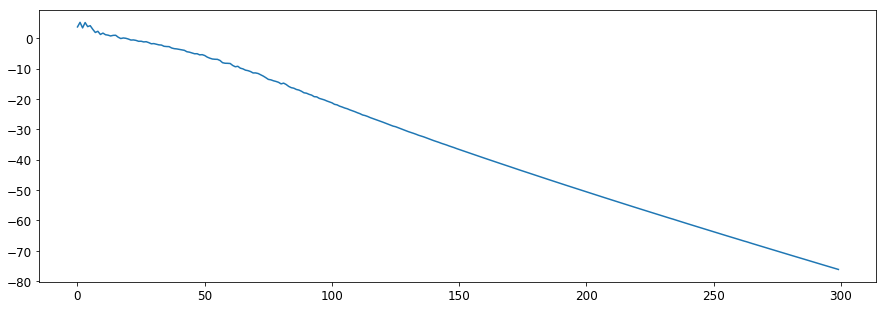

In [10]:
plt.plot(loss)

In [11]:
(out_mu, out_utriU, out_diagU) = model(statso)
U = get_U(out_diagU.squeeze(), out_utriU)
Sin = torch.mm(torch.transpose(U, 0, 1), U)

In [12]:
out_mu

Variable containing:
 2.1596  1.9622
[torch.FloatTensor of size 1x2]